# How to Schedule Web Scrapers in Python For Free in 2025: A Complete Guide

## Introduction

Web scraping is an essential skill for programmers in this data-driven world. Whether you're tracking prices, monitoring competitors, or gathering research data, automated web scraping can save you countless hours of manual work. In this comprehensive guide, you'll learn how to schedule and automate your Python web scrapers using completely free tools and services.

### Why schedule your web scraper?

Manual or one-off web scraping can be time-consuming and error-prone. You need to repeatedly run scripts, update data frequently, and sometimes work during off-hours just to gather information.

Scheduling your web scrapers automates this entire process. It collects data at optimal times without manual intervention, ensures consistency, and frees up your valuable time for actual data analysis rather than repetitive data gathering.

### What tools can you use to schedule web scrapers in Python?

If you are building scrapers in Python, you have many completely free options to schedule them.

In terms of local scraping, Python's `schedule` library is very intuitive and fastest to set up. There is also the built-in `asyncio` for concurrent scraping. There are also system-level scheduling tools like cron jobs for macOS/Linux and the Task Scheduler for Windows.

There are also many cloud-based solutions like GitHub Actions (completely free), PythonAnywhere (free tier), Google Cloud Functions (free tier), and Heroku (free tier with limitations).

In this guide, we will start with basic local scheduling and progress to using GitHub Actions, all while following best practices and ethical scraping guidelines.

Let's begin by setting up your development environment and writing your first scheduled web scraper.

### Common challenges in scheduling web scrapers

Scheduling web scrapers is an easy process, as you will discover through this tutorial. The real challenge lies in ensuring that the scrapers don't break the day after they are put on schedule. Common issues include websites changing their HTML structure, implementing new anti-bot measures, or modifying their robots.txt policies. Additionally, network issues, rate limiting, and IP blocking can cause scheduled scrapers to fail.

For these reasons, it is almost impossible to build long-lasting scrapers written in Python frameworks. But the web scraping landscape is changing as more AI-based tools are emerging, like [Firecrawl](firecrawl.dev).

Firecrawl provides an AI-powered web scraping API that can identify and extract data from HTML elements based on semantic descriptions in Python classes. While traditional scrapers rely on specific HTML selectors that can break when websites change, Firecrawl's AI approach helps maintain scraper reliability over time.

For demonstration purposes, we'll implement examples using Firecrawl, though the scheduling techniques covered in this tutorial can be applied to any Python web scraper built with common libraries like BeautifulSoup, Scrapy, Selenium, or `lxml`. If you want to follow along with a scraper of your own, make sure to have it in a script and ready to go.

## Prerequisites

This article assumes that you are already comfortable with web scraping and its related concepts like HTML structure, CSS selectors, HTTP requests, and handling rate limits. If you need a refresher on web scraping basics, check out [this introductory guide to web scraping with Python](https://realpython.com/python-web-scraping-practical-introduction/).

Otherwise, let's jump in by setting up the tools we will use for the tutorial.

### Environment setup

We will mainly use Firecrawl in this article, so, please make sure that you sign up at [firecrawl.dev](firecrawl.dev), choose the free plan and get an API token. 

Then, create a new working directory on your machine to follow along in this tutorial:

```bash
$ mkdir learn-scheduling
$ cd learn-scheduling
```

It is always a best practice to create a new virtual environment for projects. In this tutorial, we will use Python's `virtualenv`:

```bash
$ python -m venv venv
$ source venv/bin/activate  # For Unix/macOS
$ venv\Scripts\activate     # For Windows
```

Now, let's install the libraries we will use:

```bash
$ pip install requests beautifulsoup4 firecrawl-py python-dotenv
```

We will touch on what each library does as we use them.


### Firecrawl API key setup

Since we will push our code to a GitHub repository later, you will need to save your Firecrawl API key securely by using a `.env` file:

```bash
$ touch .env
$ echo "FIRECRAWL_API_KEY='your-key-here'" >> .env
```

Also, create a `.gitignore` file and add the `.env` to it so that it isn't pushed to GitHub:

```bash
$ touch .gitignore
$ echo ".env" >> .gitignore
```

## Writing a Basic Web Scraper

In this tutorial, we will build a scraper for [the Hacker News homepage](https://news.ycombinator.com/) that extracts post title, URL, author, rank, number of upvotes and date.

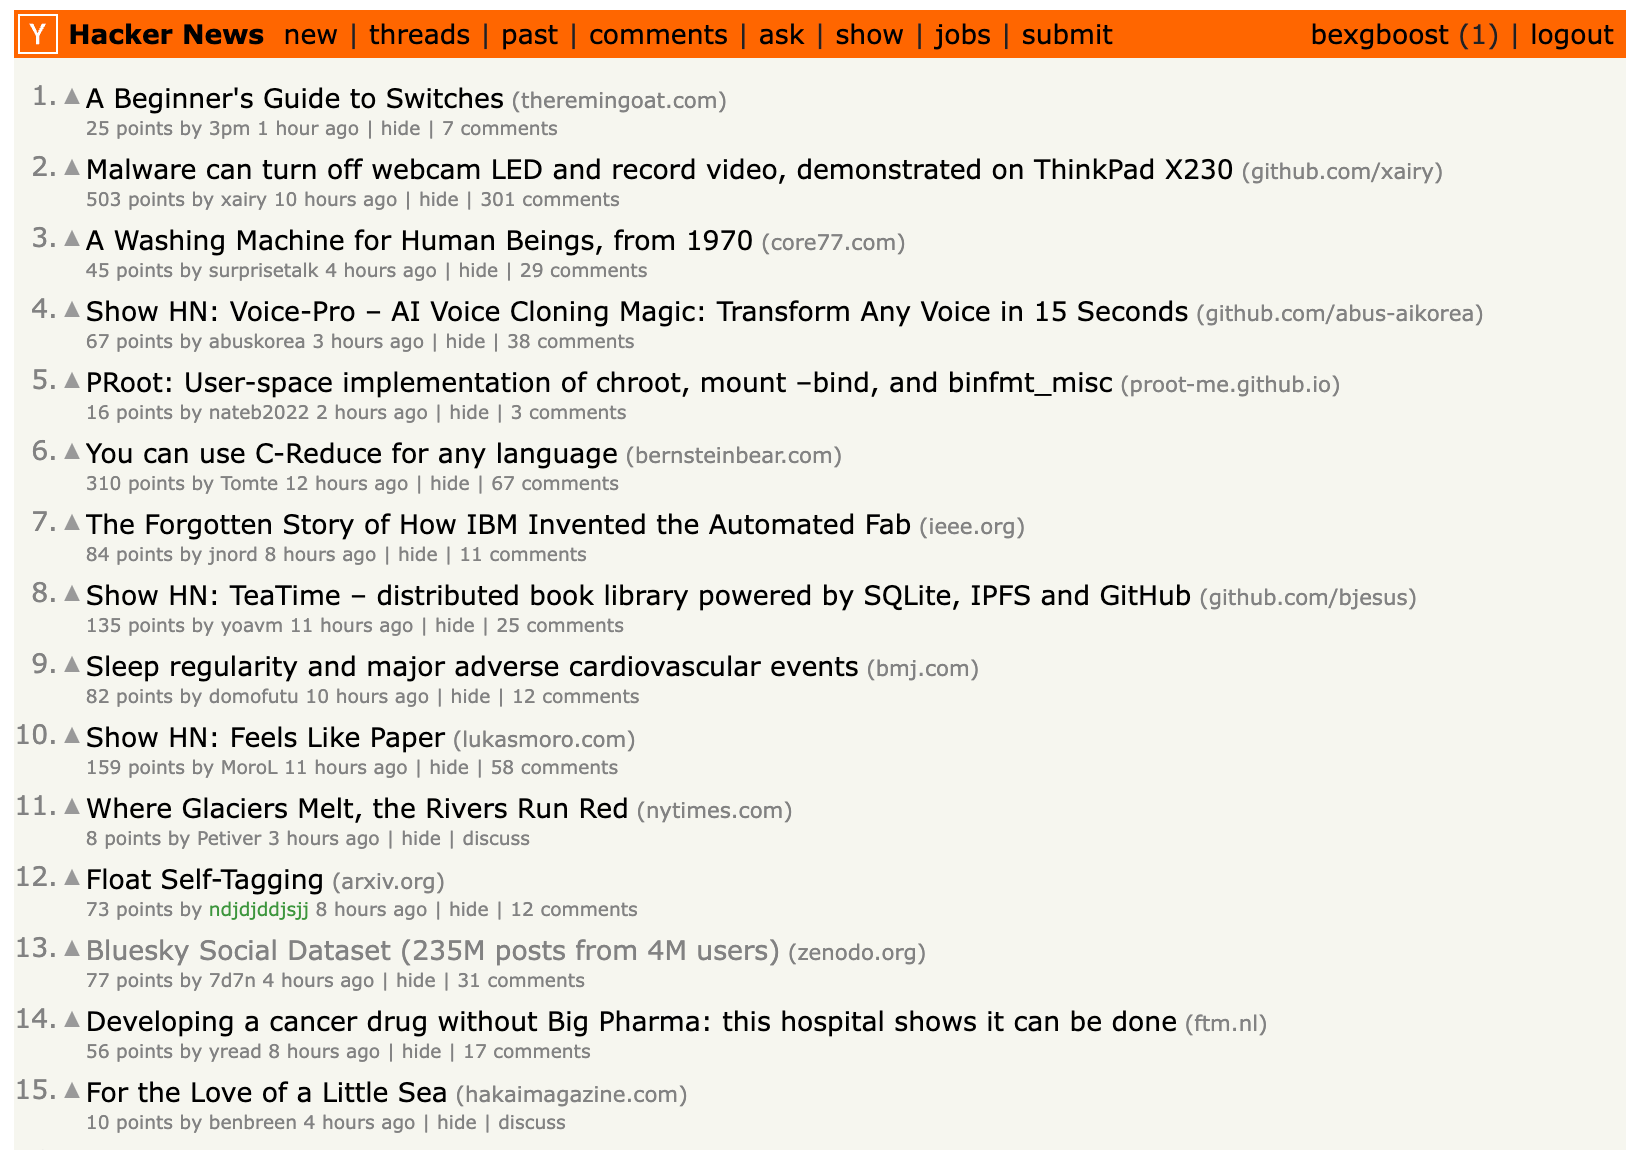

Like we mentioned, we will build the scraper in Firecrawl but I have also prepared an identical scraper written {link to the script after the PR is merged} in BeautifulSoup if you want a more traditional approach. 

-----

In your working directory, create a new `firecrawl_scraper.py` script and import the following packages:

In [1]:
# firecrawl_scraper.py
import json
from firecrawl import FirecrawlApp
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List
from datetime import datetime

load_dotenv()
BASE_URL = "https://news.ycombinator.com/"


After the imports, we are calling `load_dotenv()` so that our Firecrawl API key is loaded from the `.env` file. Then, we are defining a new variable containing the URL we will scrape. 

Next, we create a Pydantic model to specify the information we want to scrape from each Hacker News post:

In [2]:
class NewsItem(BaseModel):
    title: str = Field(description="The title of the news item")
    source_url: str = Field(description="The URL of the news item")
    author: str = Field(
        description="The URL of the post author's profile concatenated with the base URL."
    )
    rank: str = Field(description="The rank of the news item")
    upvotes: str = Field(description="The number of upvotes of the news item")
    date: str = Field(description="The date of the news item.")

Pydantic models are Python classes that provide data validation and serialization capabilities. They allow you to define the structure and types of your data using Python type hints, while automatically handling validation, serialization, and documentation.

In the context of our Firecrawl scraper, the `NewsItem` model defines the exact structure of data we want to extract from each Hacker News post. Each field in the model (`title`, `source_url`, `author`, etc.) specifies what data should be scraped and includes a description of what that field represents.

This model is crucial for Firecrawl because it uses the model's schema to understand exactly what data to extract from the webpage. When we pass this model to Firecrawl, it will automatically attempt to find and extract data matching these field definitions from the HTML structure of Hacker News.

For example, when Firecrawl sees we want a "title" field, it will look for elements on the page that are likely to contain post titles based on their HTML structure and content. The `Field` descriptions help provide additional context about what each piece of data represents.

Next, we create another model called `NewsData` that contains a list of `NewsItem` objects. This model will serve as a container for all the news items we scrape from Hacker News. The `news_items` field is defined as a List of `NewsItem` objects, which means it can store multiple news items in a single data structure.

In [3]:
class NewsData(BaseModel):
    news_items: List[NewsItem]


Without this second model, our scraper will return not one but all news items. 

Now, we define a new function that will run Firecrawl based on the scraping schema we just defined:

In [4]:
def get_firecrawl_news_data():
    app = FirecrawlApp()

    data = app.scrape_url(
        BASE_URL,
        params={
            "formats": ["extract"],
            "extract": {"schema": NewsData.model_json_schema()},
        },
    )

    return data

This function initializes a FirecrawlApp instance and uses it to scrape data from Hacker News. It passes the `BASE_URL` and parameters specifying that we want to extract data according to our `NewsData` schema. The schema tells Firecrawl exactly what fields to look for and extract from each news item on the page. The function returns the scraped data which will contain a list of news items matching our defined structure.

Let's quickly test it:

In [5]:
data = get_firecrawl_news_data()

print(type(data))

<class 'dict'>


Firecrawl always returns the scraped data in a dictionary. Let's look at the keys:

In [6]:
data['metadata']

{'title': 'Hacker News',
 'language': 'en',
 'ogLocaleAlternate': [],
 'referrer': 'origin',
 'viewport': 'width=device-width, initial-scale=1.0',
 'sourceURL': 'https://news.ycombinator.com/',
 'url': 'https://news.ycombinator.com/',
 'statusCode': 200}

The first key is the metadata field containing basic page information. We are interested in the `extract` field which contains the data scraped by the engine:

In [9]:
data['extract']['news_items'][0]

{'title': "Send someone you appreciate an official 'Continue and Persist' Letter",
 'source_url': 'https://ContinueAndPersist.org',
 'author': 'https://news.ycombinator.com/user?id=adnanaga',
 'rank': '1',
 'upvotes': '1122',
 'date': '17 hours ago'}

The `extract` field contains a dictionary with a list of scraped news items. We can see above that when printing the first item, it includes all the fields we defined in our `NewsItem` Pydantic model, including title, source URL, author, rank, upvotes and date.

In [10]:
len(data['extract']['news_items'])


30

The output shows 30 news items, confirming that our scraper successfully extracted all posts from the first page of Hacker News. This matches the site's standard layout which displays exactly 30 posts per page.

Now, let's create a new function that saves this data to a JSON file:

In [11]:
def save_firecrawl_news_data():
    # Get the data
    data = get_firecrawl_news_data()
    # Format current date for filename
    date_str = datetime.now().strftime("%Y_%m_%d_%H_%M")
    filename = f"firecrawl_hacker_news_data_{date_str}.json"

    # Save the news items to JSON file
    with open(filename, "w") as f:
        json.dump(data["extract"]["news_items"], f, indent=4)

    return filename

`save_firecrawl_news_data()` handles saving the scraped Hacker News data to a JSON file. It first calls `get_firecrawl_news_data()` to fetch the latest data from Hacker News. Then, it generates a filename using the current timestamp in the format `YYYY_MM_DD_HH_MM`. The data is saved to this timestamped JSON file with proper indentation, and the filename is returned. This allows us to maintain a historical record of the scraped data with clear timestamps indicating when each scrape occurred.

Finally, add a `__main__` block to the `firecrawl_scraper.py` script to allow running the scraper directly from the command line:

```python
if __name__ == "__main__":
    save_firecrawl_news_data()
```

The complete scraper script is available in [our GitHub repository](https://github.com/mendableai/firecrawl/blob/main/examples/hacker_news_scraper/firecrawl_scraper.py). For reference, we also provide [a BeautifulSoup implementation of the same scraper](https://github.com/mendableai/firecrawl/blob/main/examples/hacker_news_scraper/bs4_scraper.py).

## Local Scheduling Methods

In this section, we will explore how to run the scraper from the previous section on schedule using local tools like the Python `schedule` library and cron. 

### The basics of the Python `schedule` library

`schedule` is a job scheduling library written for humans ([from the documentation](https://schedule.readthedocs.io/en/stable/index.html)). It runs any Python function or callable periodically using intuitive syntax. 

To get started, please install it with `pip`:

```bash
$ pip install schedule
```

Then, scheduling a Python function is as easy as shown in the codeblock below:

```python
import schedule
import time

def job():
    current_time = time.strftime("%H:%M:%S")
    print(f"{current_time}: I'm working...")

# Schedule it
schedule.every(3).seconds.do(job)

while True:
    schedule.run_pending()
    time.sleep(1)
```

```out
14:58:23: I'm working...
14:58:26: I'm working...
14:58:29: I'm working...
14:58:32: I'm working...
14:58:35: I'm working...
...
```

To implement scheduling, first convert your task into a function (which we've already completed). Next, apply scheduling logic using the `.every(n).period.do` syntax. Below are several examples demonstrating different scheduling patterns:

```python
schedule.every(10).minutes.do(job)
schedule.every().hour.do(job)
schedule.every().day.at("10:30").do(job)
schedule.every().monday.do(job)
schedule.every().wednesday.at("13:15").do(job)
schedule.every().day.at("12:42", "Europe/Amsterdam").do(job)
schedule.every().minute.at(":17").do(job)  # 17th second of a minute
```

Finally, you need to run an infinite loop that checks for pending scheduled jobs and executes them. The loop below runs continuously, checking if any scheduled tasks are due to run:

```python
while True:
    schedule.run_pending()
    time.sleep(1)
```


There is much more to the `schedule` library than what we just covered (you should check out [the examples from the documentation](https://schedule.readthedocs.io/en/stable/examples.html)) but they are enough for the purposes of this article. 

### Using Python's `schedule` library to schedule web scrapers

Now that we know the basics of `schedule`, let's use it for our Firecrawl scraper. Start by creating a new `scrape_scheduler.py` script and making the necessary imports:

In [56]:
import schedule
import time
from firecrawl_scraper import save_firecrawl_news_data

Here, we import the `schedule` module itself and the `save_firecrawl_news_data()` function from `firecrawl_scraper.py` that downloads the top 30 posts of Hacker News. 

Then, to run this function on schedule, like every hour, we only need to add a few lines of code:

In [ ]:
# Schedule the scraper to run every hour
schedule.every().hour.do(save_firecrawl_news_data)

while True:
    schedule.run_pending()
    time.sleep(1)

You can start the schedule with:

```bash
$ python scrape_scheduler.py
```

> **Tip**: For debugging purposes, start with a shorter interval like 60 seconds before implementing the hourly schedule.

The scheduler will continue running until you terminate the main terminal process executing the `scrape_scheduler.py` script. Thanks to Firecrawl's AI-powered HTML parsing and layout adaptation capabilities, the scraper is quite resilient to website changes and has a low probability of breaking.

Nevertheless, web scraping can be unpredictable, so it's recommended to review [the exception handling](https://schedule.readthedocs.io/en/stable/exception-handling.html) section of the `schedule` documentation to handle potential errors gracefully.

-----

The `schedule` library provides a simple and intuitive way to run periodic tasks like web scrapers. While it lacks some advanced features of other scheduling methods, it's a great choice for basic scheduling needs and getting started with automated scraping. Just remember to implement proper error handling for production use.

### Using Python's built-in tools to schedule web scrapers

In this section, we will explore a few other local scheduling methods that have the advantage of being built into Python or the operating system, making them more reliable and robust than third-party libraries. These methods also provide better error handling, logging capabilities, and system-level control over the scheduling process.

#### How to schedule a web scraper with `asyncio`?

`asyncio` is a Python library for running code concurrently - executing multiple tasks at the same time by switching between them when one is waiting. It's built into Python and helps schedule tasks efficiently. Here's why it's great for web scrapers:

1. It can do other work while waiting for web requests to complete.
2. You can run multiple scrapers at the same time with precise timing control.
3. It uses less computer resources than regular multitasking.
4. It handles errors well with `try/except` blocks.

Let's see how to use `asyncio` for scheduling scrapers:

In [ ]:
import asyncio
import time
from firecrawl_scraper import save_firecrawl_news_data


async def schedule_scraper(interval_hours: float = 1):
    while True:
        try:
            print(f"Starting scrape at {time.strftime('%Y-%m-%d %H:%M:%S')}")
            # Run the scraper
            filename = save_firecrawl_news_data()
            print(f"Data saved to {filename}")

        except Exception as e:
            print(f"Error during scraping: {e}")

        # Wait for the specified interval
        await asyncio.sleep(interval_hours * 3600)  # Convert hours to seconds


async def main():
    # Create tasks for different scheduling intervals
    tasks = [
        schedule_scraper(interval_hours=1),  # Run every hour
        # Add more tasks with different intervals if needed
        # schedule_scraper(interval_hours=0.5),  # Run every 30 minutes
        # schedule_scraper(interval_hours=2),    # Run every 2 hours
    ]

    # Run all tasks concurrently
    await asyncio.gather(*tasks)


if __name__ == "__main__":
    # Run the async scheduler
    asyncio.run(main())

Let's break down what's happening above:

The `schedule_scraper()` function is an `async` function that runs indefinitely in a loop. For each iteration, it:
1. Runs the scraper and saves the data
2. Handles any errors that occur during scraping
3. Waits for the specified interval using `asyncio.sleep()`

The `main()` function sets up concurrent execution of multiple scraper tasks with different intervals. This allows running multiple scrapers simultaneously without blocking each other.

This asyncio-based approach has several advantages over the `schedule` library:

1. True concurrency: Multiple scrapers can run simultaneously without blocking each other, unlike `schedule` which runs tasks sequentially.

2. Precise Timing: `asyncio.sleep()` provides more accurate timing control compared to schedule's `run_pending()` approach.

3. Resource Efficiency: `asyncio` uses cooperative multitasking which requires less system resources than `schedule`'s threading-based approach.

4. Better Error Handling: `Async/await` makes it easier to implement proper error handling and recovery

5. Flexibility: You can easily add or remove scraper tasks and modify their intervals without affecting other tasks

The code structure also makes it simple to extend functionality by adding more concurrent tasks or implementing additional error handling logic.


#### How to schedule a web scraper with cron jobs?

Cron is a time-based job scheduler in Unix-like operating systems (Linux, macOS). Think of it as a digital scheduler or calendar that can automatically run programs at specified times. A cron job is simply a task that you schedule to run at specific intervals.

For web scraping, cron jobs are incredibly useful because they let you automate your scraper to run at predetermined times. For example, you could set up a cron job to:

- Run your scraper every hour to collect real-time data
- Execute scraping tasks during off-peak hours (like 2 AM) to minimize server load
- Collect data at specific times when websites update their content

The scheduling format uses five time fields: minute, hour, day of month, month, and day of week. For instance:

- `0 * * * *` means "run every hour at minute 0"
- `0 0 * * *` means "run at midnight every day"
- `*/15 * * * *` means "run every 15 minutes"

Cron jobs are especially reliable for web scraping because they're built into the operating system, use minimal resources, and continue running even after system reboots.

So, let's run the `save_firecrawl_news_data()` function on a schedule using cron. First, we will create a dedicated script for the cron job named `cron_scraper.py`:


In [ ]:
# cron_scraper.py
import sys
import logging
from datetime import datetime
from pathlib import Path
from firecrawl_scraper import save_firecrawl_news_data

# Set up logging
log_dir = Path("logs")
log_dir.mkdir(exist_ok=True)
log_file = log_dir / f"scraper_{datetime.now().strftime('%Y_%m')}.log"

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[logging.FileHandler(log_file), logging.StreamHandler(sys.stdout)],
)


def main():
    try:
        logging.info("Starting scraping job")
        filename = save_firecrawl_news_data()  # Actual scraping function
        logging.info(f"Successfully saved data to {filename}")
    except Exception as e:
        logging.error(f"Scraping failed: {str(e)}", exc_info=True)


if __name__ == "__main__":
    main()

The script implements a production-ready web scraper with logging and error handling. It creates a logs directory, configures detailed logging to both files and console, and wraps the scraping operation in error handling. When run, it executes our scraper function while tracking its progress and any potential issues, making it ideal for automated scheduling through cron jobs.

Now, to schedule this script using cron, you will need to:

1. Make the script executable:

```bash
$ chmod +x cron_scraper.py
```

2. Open your crontab file (which is usually empty) with Nano:

```bash
$ EDITOR=nano crontab -e
```

Then, add one or more entries specifying the frequency with which the scraper must run:

```python
# Run every minute
*/1 * * * * cd /absolute/path/to/project && /absolute/path/to/.venv/bin/python cron_scraper.py >> ~/cron.log 2>&1

# Run every hour
*/1 * * * * cd /absolute/path/to/project && /absolute/path/to/.venv/bin/python cron_scraper.py >> ~/cron.log 2>&1
```

The above cron job syntax consists of several parts:

The timing pattern "*/1 * * * *" breaks down as follows:
- First `*/1`: Specifies every minute
- First `*`: Represents any hour
- Second `*`: Represents any day of the month  
- Third `*`: Represents any month
- Fourth `*`: Represents any day of the week

After the timing pattern:
- `cd /absolute/path/to/project`: Changes to the project directory of your scraper
- `&&`: Chains commands, executing the next only if previous succeeds
- `/absolute/path/to/.venv/bin/python`: Specifies the Python interpreter path
- `cron_scraper.py`: The script to execute
- `>> ~/cron.log 2>&1`: Redirects both standard output (>>) and errors (`2>&1`) to `cron.log`

For hourly execution, the same pattern applies but with "0 * * * *" timing to run at the start of each hour instead of every minute.

As soon as you save your crontab file with these commands, the schedule starts and you should see a `logs` directory in the same folder as your `cron_scraper.py`. It must look like this if you have been following along:

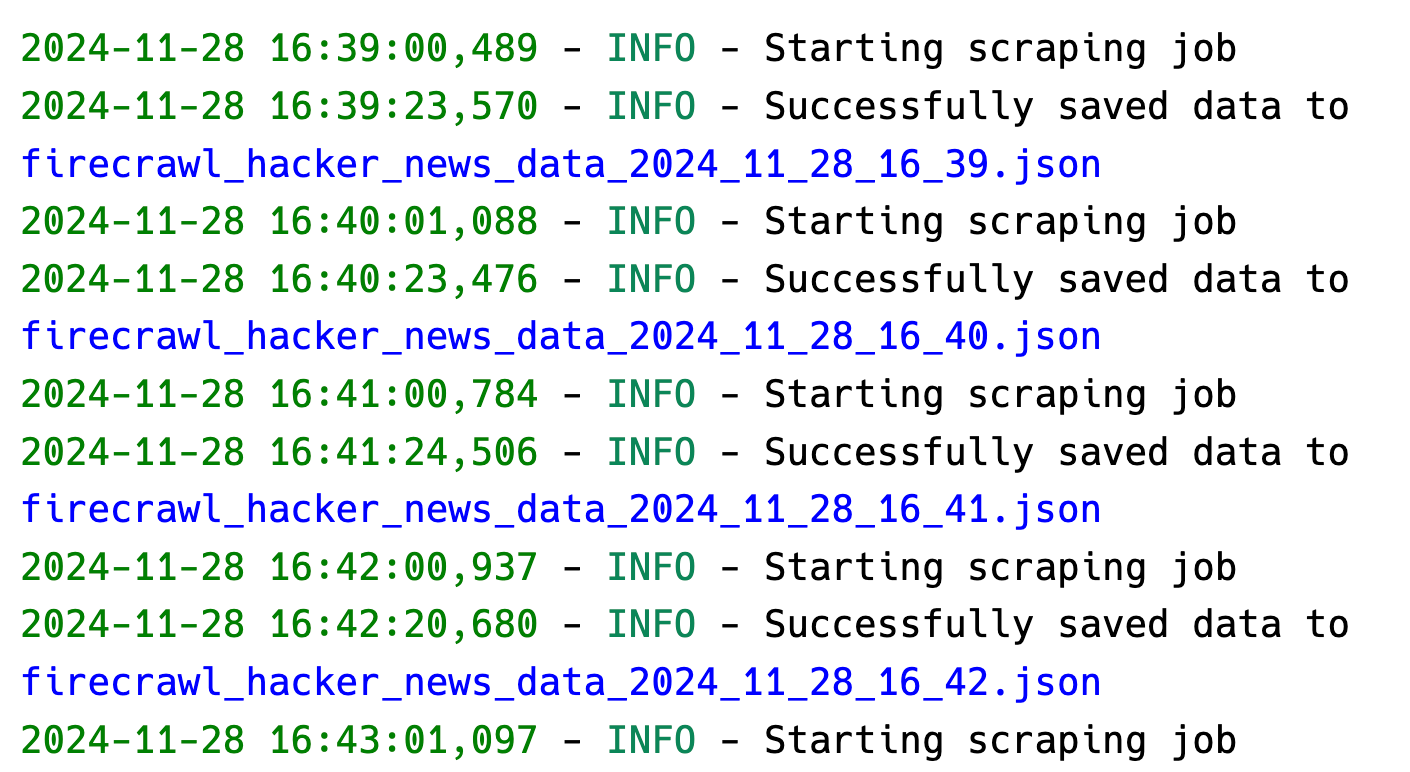

You can always check the status of your cron jobs with the following command as well:

```bash
$ tail -f ~/cron.log
```

To cancel a cron job, simply open your crontab file again and remove the line corresponding to the job.

#### How to schedule a web scraper using Windows Task Scheduler?

Windows Task Scheduler is a built-in Windows tool that can automate running programs or scripts at specified times. It's a robust alternative to cron jobs for Windows users. Let's set up our scraper to run automatically:

1. First, create a batch file (`run_scraper.bat`) to run our Python script:

```python
@echo off
cd /d "C:\path\to\your\project"
call venv\Scripts\activate
python cron_scraper.py
deactivate
```

2. To set up the task in Windows Task Scheduler:

- Open Task Scheduler (search "Task Scheduler" in Windows search)
- Click "Create Basic Task" in the right panel
- Follow the wizard:
  - Name: "Hacker News Scraper"
  - Description: "Scrapes Hacker News hourly"
  - Trigger: Choose when to run (e.g., "Daily")
  - Action: "Start a program"
  - Program/script: Browse to your `run_scraper.bat`
  - Start in: Your project directory

For more control over the task, you can modify its properties after creation:

- Double-click the task
- In the "Triggers" tab, click "Edit" to set custom schedules
- Common scheduling options:
  - Run every hour
  - Run at specific times
  - Run on system startup
- In the "Settings" tab, useful options include:
  - "Run task as soon as possible after a scheduled start is missed"
  - "Stop the task if it runs longer than X hours"

The Task Scheduler provides several advantages:

- Runs even when user is logged out
- Detailed history and logging
- Ability to run with elevated privileges
- Options for network conditions
- Retry logic for failed tasks

You can monitor your scheduled task through the Task Scheduler interface or check the logs we set up in `cron_scraper.py`.

## Scheduling Web Scrapers With GitHub Actions

One disadvantage all local scheduling methods have is that they rely on your local machine being powered on and connected to the internet. If your computer is turned off, loses power, or loses internet connectivity, your scheduled scraping tasks won't run. This is where cloud-based solutions like GitHub Actions can provide more reliability and uptime for your web scraping workflows.

### What is GitHub Actions?

GitHub Actions is a continuous integration and deployment (CI/CD) platform provided by GitHub that allows you to automate various workflows directly from your [GitHub](github.com) repository. 

For web scraping, GitHub Actions provides a reliable way to schedule and run your scraping scripts in the cloud. You can define workflows using YAML files that specify when and how your scraper should run, such as on a regular schedule using cron syntax. This means your scraping jobs will continue running even when your local machine is off, as they execute on GitHub's servers.

### Step 1: Setting Up a GitHub repository

To schedule our scrapers with GitHub actions, we first need a GitHub repository. Start by initializing Git in your current workspace:

```bash
# Initialize git in your project directory
git init
git add .
git commit -m "Initial commit"
```

Next, create a new public or private GitHub repository and add it as the remote:

```bash
# Create a new repo on GitHub.com, then:
git remote add origin https://github.com/YOUR_USERNAME/YOUR_REPO_NAME.git
git branch -M main
git push -u origin main
```

Then, create the following directory structure:

```bash
mkdir -p .github/workflows
```

This directory will contain our GitHub Actions workflow files with YAML format. These files define how and when our scraping scripts should run. The workflows can be scheduled using cron syntax, triggered by events like pushes or pull requests, and can include multiple steps like installing dependencies and running scripts.

### Step 2: Creating a Workflow file

At this stage, create a new `scraper.yml` file inside `.github/workflows` and paste the following contents:

```yaml
name: Run Firecrawl Scraper

on:
  schedule:
    - cron: "0/5 * * * *" # Runs every five minute
  workflow_dispatch: # Allows manual trigger

jobs:
  scrape:
    runs-on: ubuntu-latest

    steps:
      - uses: actions/checkout@v3

      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: "3.9"

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install pydantic firecrawl-py

      - name: Run scraper
        run: python firecrawl_scraper.py
        env:
          # Add any environment variables your scraper needs
          FIRECRAWL_API_KEY: ${{ secrets.FIRECRAWL_API_KEY }}

      - name: Commit and push if changes
        run: |
          git config --global user.name 'GitHub Actions Bot'
          git config --global user.email 'actions@github.com'
          git add .
          git commit -m "Update scraped data" || exit 0
          git push
```

Let's break down the key components of this GitHub Actions workflow file:

Workflow name:
The workflow is named "Run Firecrawl Scraper" which helps identify it in the GitHub Actions interface.

Triggers:
- Scheduled to run every 5 minutes using cron syntax "0/5 * * * *" (5 minutes is for debugging purposes, please change to hourly later)
- Can be manually triggered using `workflow_dispatch`

Job configuration:
- Runs on latest Ubuntu virtual environment
- Contains multiple sequential steps

Step details:
1. Checkout:
   - Uses `actions/checkout@v3` to get repository code
   
2. Python Setup:
   - Uses `actions/setup-python@v4`
   - Configures Python 3.9 environment

3. Dependencies:
   - Upgrades `pip`
   - Installs required packages: `pydantic` and `firecrawl-py`

4. Scraper Execution:
   - Runs `firecrawl_scraper.py`
   - Uses `FIRECRAWL_API_KEY` from repository secrets
5. Committing the changes:
    - Creates a commit persisting the downloaded data using GitHub Actions bot. 

To run this action successfully, you'll need to store your Firecrawl API key in GitHub secrets. Navigate to your repository's Settings, then Secrets and variables → Actions. Click the "New repository secret" button and add your API key, making sure to use the exact key name specified in `scraper.yml`.

After ensuring that everything is set up correctly, commit and push the latest changes to GitHub:

```bash
$ git add .
$ git commit -m "Add a workflow to scrape on a schedule"
```

Once you do, the workflow must show up in the Actions tab of your repository like below:

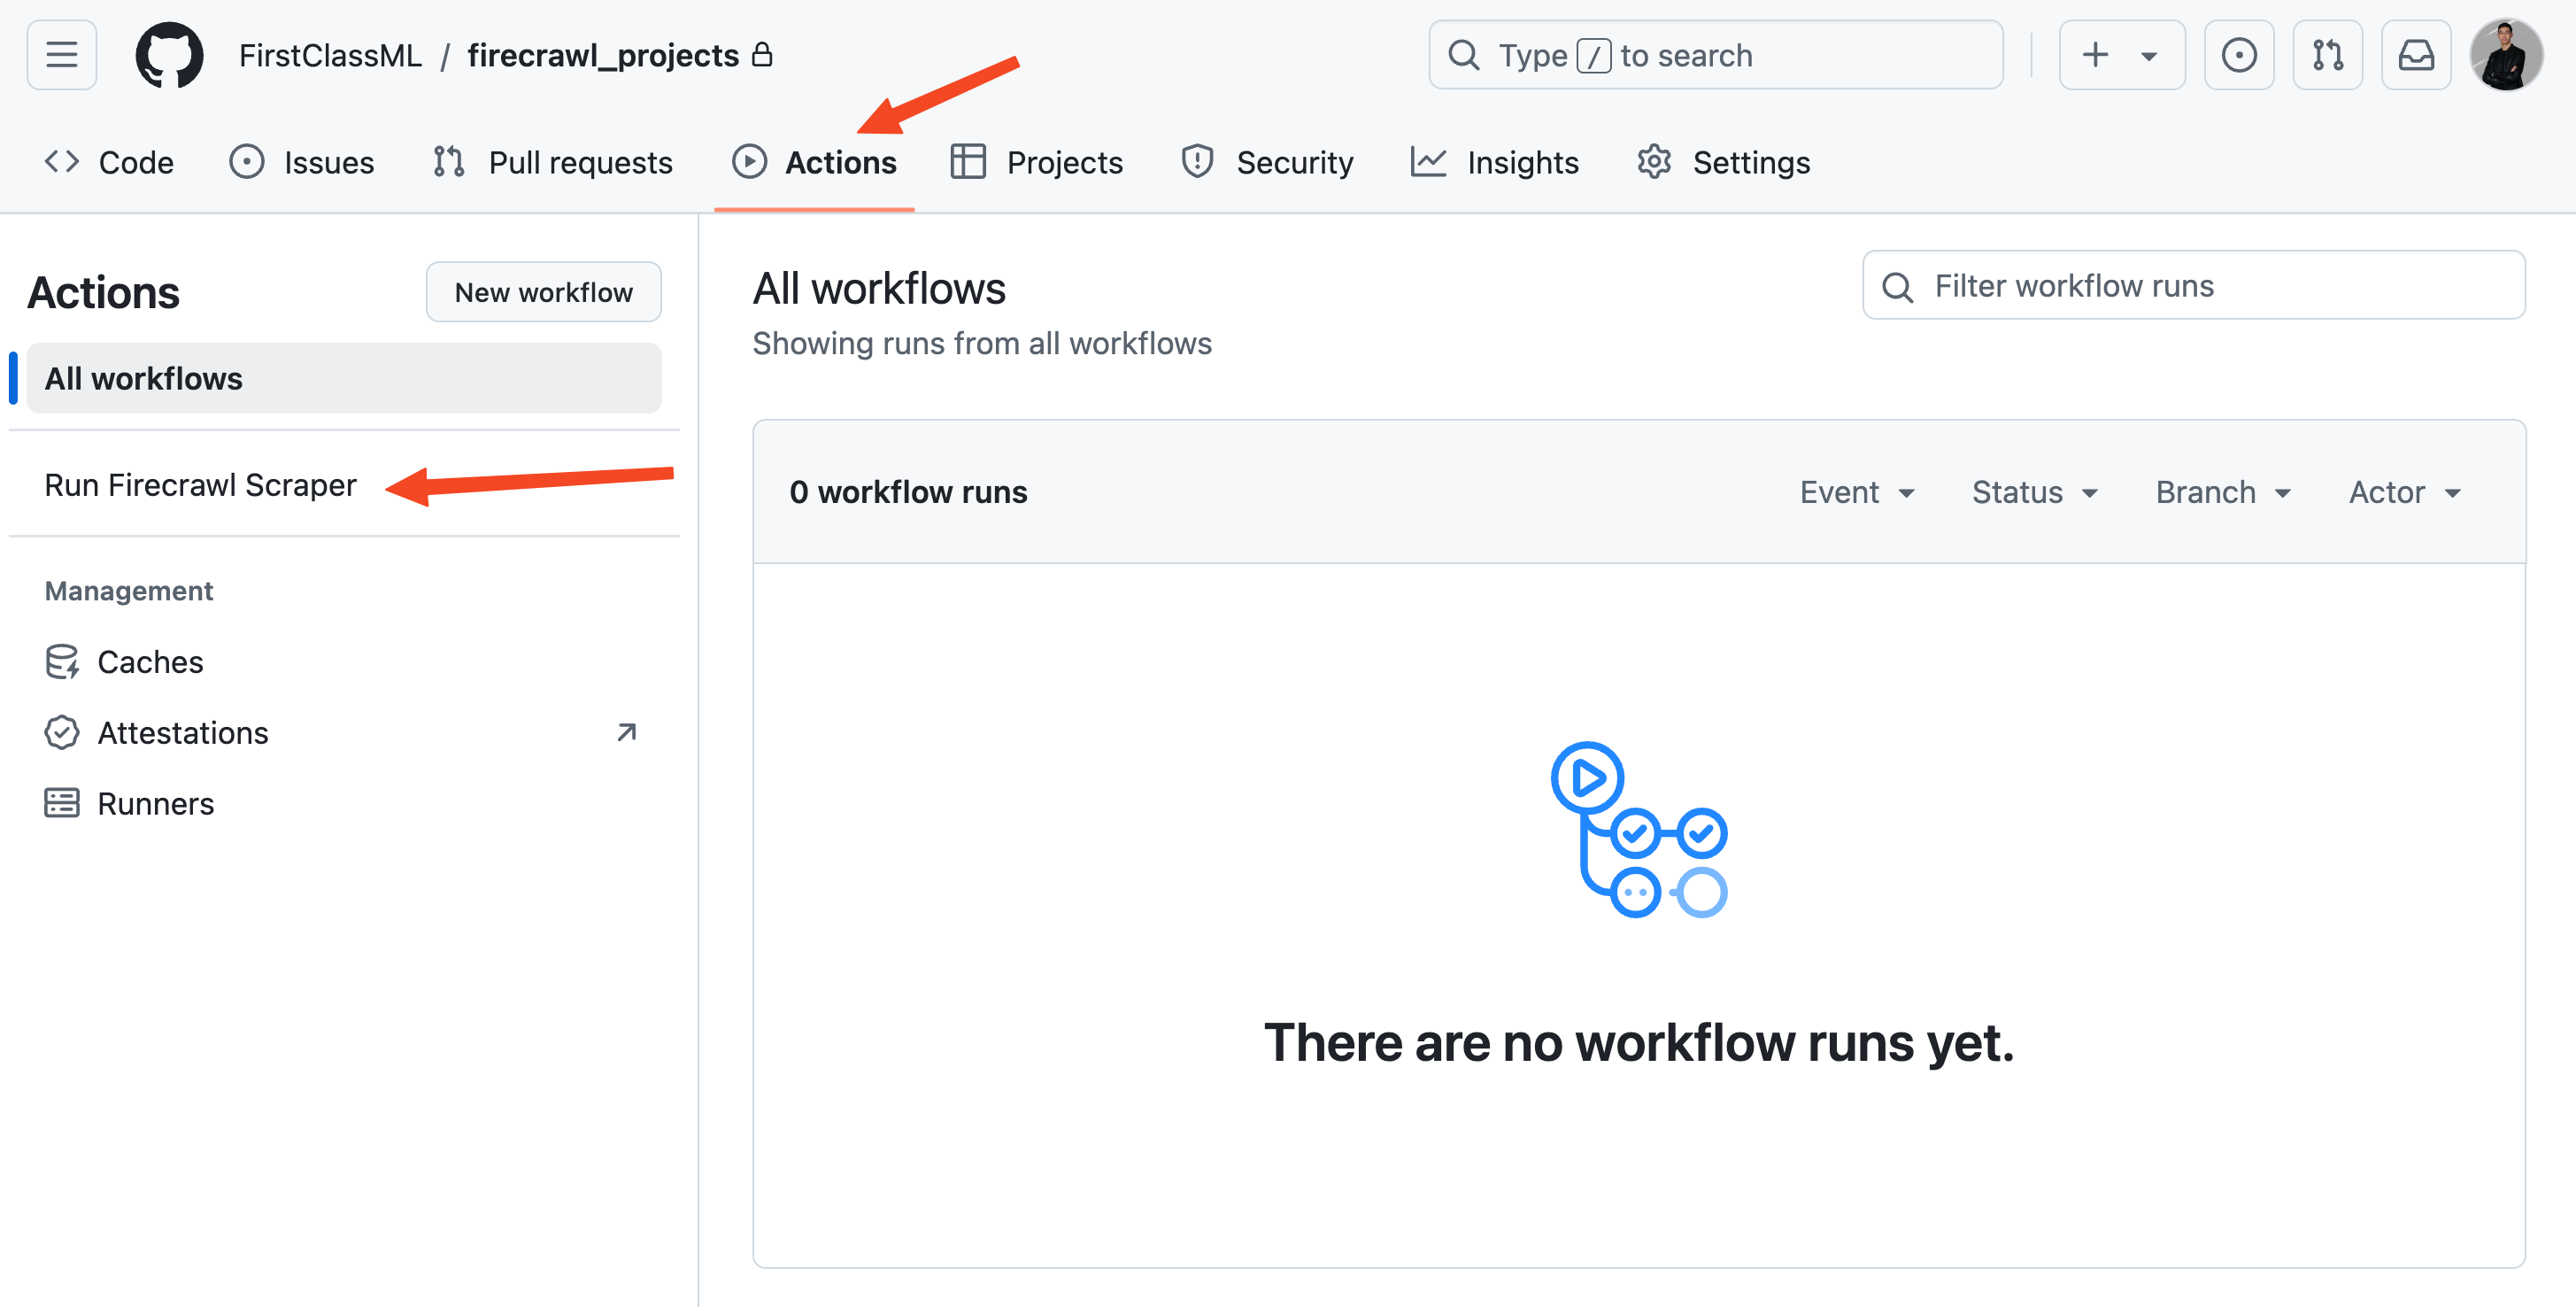

Click on the workflow name and press the "Run workflow" button. This launches the action manually and starts the schedule. If you check in after some time, you should see more automatic runs and the results persisted in your repository:

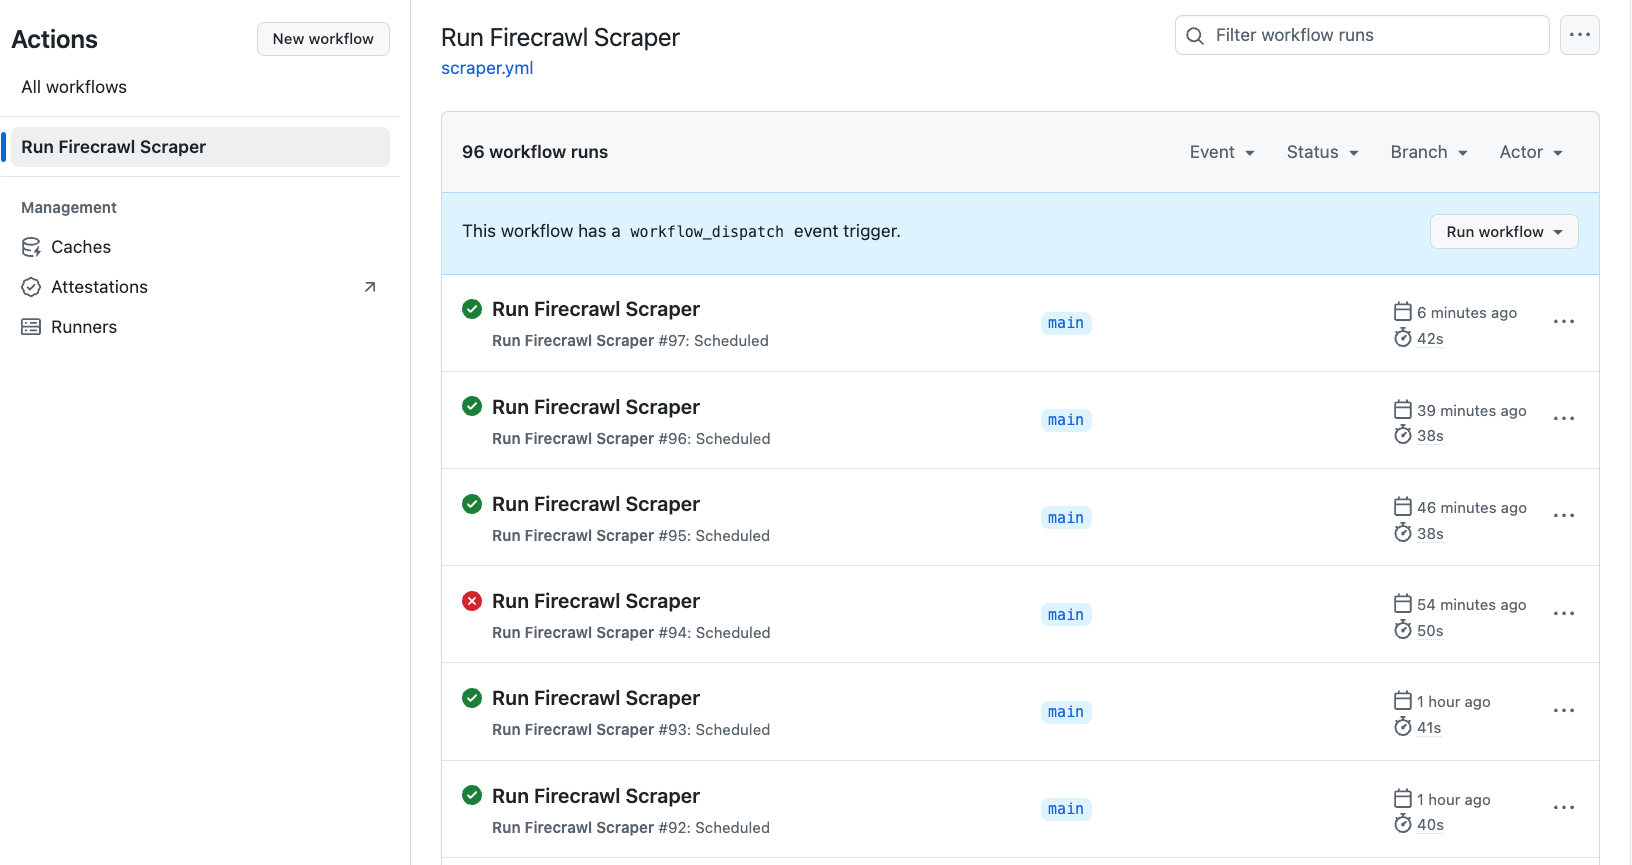

Caption: I left the workflow running overnight (at five minute intervals) and was nastily surprised by 96 workflow runs the next day. Thankfully, GitHub actions are free (up to 2000 min/month) unlike AWS instances.

Now, unless you disable the workflow manually by clicking the three dots in the upper-right corner, the scraper continues running on the schedule you specified. 

## Best Practices and Optimization

When scheduling web scrapers, following best practices ensures reliability, efficiency, and ethical behavior. Here are the key areas to consider:

### 1. Rate limiting and delays

Scraping engines like Firecrawl usually come with built-in rate limiting. However, if you are using custom scrapers written with Python libraries, you must always respect website servers by implementing proper rate limiting and delay strategies. For example, the below example shows adding random delays between your requests in-between requests to respect server load and avoid getting your IP blocked:

```python
import time
import random

def scrape_with_delays(urls):
    for url in urls:
        try:
            # Random delay between 2-5 seconds
            delay = random.uniform(2, 5)
            time.sleep(delay)
            
            # Your scraping code here
            response = requests.get(url)
            
        except requests.RequestException as e:
            logging.error(f"Error scraping {url}: {e}")
```

Best practices for rate limiting:
- Add random delays between requests (2-5 seconds minimum)
- Respect `robots.txt` directives
- Implement exponential backoff for retries
- Stay under 1 request per second for most sites
- Monitor response headers for rate limit information

### 2. Proxy Rotation

This best practice is related to using custom web scrapers. Proxy rotation involves cycling through different IP addresses when making requests to avoid getting blocked. By distributing requests across multiple IPs, you can maintain access to websites that might otherwise flag high-volume traffic from a single source.

```python
from itertools import cycle

def get_proxy_pool():
    proxies = [
        'http://proxy1:port',
        'http://proxy2:port',
        'http://proxy3:port'
    ]
    return cycle(proxies)

def scrape_with_proxies(url, proxy_pool):
    for _ in range(3):  # Max 3 retries
        try:
            proxy = next(proxy_pool)
            response = requests.get(
                url,
                proxies={'http': proxy, 'https': proxy},
                timeout=10
            )
            return response
        except requests.RequestException:
            continue
    return None
```

Proxy best practices:
- Rotate IPs regularly
- Use high-quality proxy services
- Implement timeout handling
- Monitor proxy health
- Keep backup proxies ready

### 3. Data Storage Strategies

The example scrapers we have built today saved the data to a JSON file, which is a simple method. Based on your needs, you may consider building a full data storage solution that saves the scraped data to various formats like as CSV files or to an SQL database. The storage type always depends on the kind of information scraped. Below is an example class that can save lists of dictionaries (like we scraped today) to a CSV file:

```python
from datetime import datetime
import json
import pandas as pd

class DataManager:
    def __init__(self, base_path='data'):
        self.base_path = Path(base_path)
        self.base_path.mkdir(exist_ok=True)
    
    def save_data(self, data, format='csv'):
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        if format == 'csv':
            filename = self.base_path / f'data_{timestamp}.csv'
            pd.DataFrame(data).to_csv(filename, index=False)
        elif format == 'json':
            filename = self.base_path / f'data_{timestamp}.json'
            with open(filename, 'w') as f:
                json.dump(data, f, indent=2)
        
        # Cleanup old files (keep last 7 days)
        self._cleanup_old_files(days=7)
        
        return filename
    
    def _cleanup_old_files(self, days):
        # Implementation for cleaning up old files
        pass
```

Storage recommendations:
- Use appropriate file formats (CSV/JSON/Database)
- Implement data versioning
- Regular cleanup of old data
- Compress historical data
- Consider using a database for large datasets

### 4. Error Logging and Monitoring

Web scraping usually requires more sophisticated logging than plain old print statements. Save the following or bookmark it on your browser as it properly sets up a logger using the built-in `logging` module of Python:

```python
import logging
from pathlib import Path

def setup_logging():
    log_dir = Path('logs')
    log_dir.mkdir(exist_ok=True)
    
    # File handler for detailed logs
    file_handler = logging.FileHandler(
        log_dir / f'scraper_{datetime.now().strftime("%Y%m%d")}.log'
    )
    file_handler.setLevel(logging.DEBUG)
    
    # Console handler for important messages
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    
    # Configure logging
    logging.basicConfig(
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        handlers=[file_handler, console_handler]
    )
```

Monitoring best practices:
- Implement comprehensive logging
- Set up alerts for critical failures
- Monitor memory usage
- Track success rates
- Log response times

### 5. Maintaining Your Scraper

Maintaining your web scraper is crucial for ensuring reliable and continuous data collection. Web scraping targets are dynamic - websites frequently update their structure, implement new security measures, or change their content organization. Regular maintenance helps catch these changes early, prevents scraping failures, and ensures your data pipeline remains robust. A well-maintained scraper also helps manage resources efficiently, keeps code quality high, and adapts to evolving requirements.

Maintenance guidelines:
- Regular code updates
- Monitor site changes
- Update user agents periodically
- Check for library updates
- Implement health checks
- Document maintenance procedures

## Conclusion

Throughout this guide, we've explored how to effectively schedule web scrapers using local Python and operation system tools as well as GitHub actions. From basic setup to advanced optimization techniques, we've covered the essential components needed to build reliable, automated data collection pipelines. The workflow we've created not only handles the technical aspects of scheduling but also incorporates best practices for rate limiting, error handling, and data storage - crucial elements for any production-grade scraping system.

For those looking to enhance their web scraping capabilities further, I recommend exploring Firecrawl's comprehensive features through their [/crawl endpoint guide](https://www.firecrawl.dev/blog/mastering-the-crawl-endpoint-in-firecrawl) and [/scrape endpoint tutorial](https://www.firecrawl.dev/blog/mastering-firecrawl-scrape-endpoint). These resources, along with the [official documentation](https://docs.firecrawl.dev), provide deeper insights into advanced topics like JavaScript rendering, structured data extraction, and batch operations that can significantly improve your web scraping workflows. Whether you're building training datasets for AI models or monitoring websites for changes, combining scheduled scraping with these powerful tools can help you build more sophisticated and efficient data collection systems.

## FAQ
- Common questions about scheduled scraping
- Performance optimization
- Scaling considerations